# Import

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
from facenet_pytorch import MTCNN
from tqdm import tqdm
from glob import glob
from IPython import display
from matplotlib import pyplot as plt
from IPython.display import Image, display
import os
import pandas as pd
import matplotlib.pyplot as plt
import keras
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Dropout
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.applications.xception import Xception

2023-11-30 14:31:17.029114: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-30 14:31:17.163250: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-30 14:31:18.489344: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/elicer/.local/lib/python3.10/site-packages/cv2/../../lib64:/usr/local/nvidia/lib:

# Data Read
- 데이터는 대회장에서 주어진 /mnt/elice/dataset 디렉토리에 있는 REAL, FAKE가 구분되있는 약 10000개의 영상으로 구성
- 각 영상을 프레임 단위로 분할한 후 모델 훈련을 위해 얼굴부분만을 crop

In [2]:
TRAIN_PATH = '/mnt/elice/dataset/train'
TEST_PATH = '/mnt/elice/dataset/test'
train_files = sorted(glob(TRAIN_PATH+'/*/*'))
real_files = sorted(glob(TRAIN_PATH+'/real/*'))
fake_files = sorted(glob(TRAIN_PATH+'/fake/*'))
labels = [label.split('/')[-2] for label in train_files]
real_label = [label.split('/')[-2] for label in real_files]
fake_label = [label.split('/')[-2] for label in fake_files]

In [12]:
def chimac(videos, num, label):
    count = 0
    file = videos.split("/")[-1]
    fileName = file.split(".")[0]
    mtcnn = MTCNN(margin=50, keep_all=True, post_process=True, device='cuda:0', thresholds=[.9, .9, .9])
    v_cap = cv2.VideoCapture(videos)
    v_len = int(v_cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    # 디렉터리가 없으면 생성
    output_dir = f'/home/elicer/{label}/'
    os.makedirs(output_dir, exist_ok=True)

    for i in range(v_len):
        success = v_cap.grab()
        if i % (v_len//30) == 0:
            success, frame = v_cap.retrieve()
        else:
            continue
        if not success:
            continue
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        # 얼굴 감지 및 저장
        final_dir = f'{output_dir}/{num}'
        os.makedirs(final_dir, exist_ok=True)
        face = mtcnn(frame, save_path=f'{final_dir}/{fileName}{count}.jpg')
        count += 1

    v_cap.release()
    

In [13]:
from tqdm import tqdm
import time

for vid_no in tqdm(range(len(real_files)), desc='진행 중'):  
    vid = real_files[vid_no]  
    chimac(vid, f'r{vid_no}', 'real_data')


진행 중: 100%|██████████| 3500/3500 [1:56:38<00:00,  2.00s/it]  


In [14]:
for vid_no in tqdm(range(len(fake_files)), desc='진행 중'):  
    vid = fake_files[vid_no]
    chimac(vid, f'f{vid_no}', 'fake_data')
    


진행 중: 100%|██████████| 3500/3500 [1:23:05<00:00,  1.42s/it]


In [3]:
real_train_dir = '/home/elicer/real_data/'

real_train = [real_train_dir + x+'/' for x in sorted(os.listdir(real_train_dir))]
r_train = []
for rt in real_train:
    r_train = r_train+[rt + x for x in sorted(os.listdir(rt))]

fake_train_dir = '/home/elicer/fake_data/'
fake_train = [fake_train_dir + x+'/' for x in sorted(os.listdir(fake_train_dir))]
f_train = []
for ft in fake_train:
    f_train = f_train+[ft + x for x in sorted(os.listdir(ft))]



# Train/Test Split

In [4]:
train_path = r_train[:90000] + f_train[:90000]
train_label = ['0']*90000 + ['1']*90000
train_df = pd.DataFrame({'path': train_path, 'label':train_label})
train_df = shuffle(train_df)
len(train_df)

180000

In [5]:
val_path = r_train[90000:] + f_train[90000:]
val_label = ['0']*(len(r_train[90000:])) + ['1']*(len(f_train[90000:]))
val_df = pd.DataFrame({'path': val_path, 'label':val_label})
val_df = shuffle(val_df)
len(val_df)

30405

# Data Augmentation

- 과적합 방지 및 데이터 다양성을 위한 작업
- 이미지 회전, 반전, 채도 변경, 크기 스케일링 등 여러 변환 방식이 들어가 있다.

In [6]:
train_datagen = ImageDataGenerator(
    rotation_range=270,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    rescale=1/255,
    brightness_range=(0.5, 1.5),
    zoom_range=[0.8, 1.2],
    channel_shift_range=50.0  # 채도 변환 추가
)

In [7]:
val_datagen = ImageDataGenerator(rescale = 1/255)

In [8]:
IM_HEIGHT = 160
IM_WIDTH = 160

train_generator = train_datagen.flow_from_dataframe(train_df, x_col="path", y_col="label", target_size=(IM_HEIGHT, IM_WIDTH),
                                                   batch_size=16, class_mode='binary', shuffle=True)

val_generator = val_datagen.flow_from_dataframe(val_df, x_col="path", y_col="label", target_size=(IM_HEIGHT, IM_WIDTH),
                                                   batch_size=16, class_mode='binary', shuffle=True)

Found 180000 validated image filenames belonging to 2 classes.
Found 30405 validated image filenames belonging to 2 classes.


# Create Model, training
- Xception 구조를 갖는 Model 생성
- epoch의 변화에 따른 validation set의 loss, accuracy 변화에 집중

In [10]:
Xception = Xception(input_shape=(IM_HEIGHT, IM_WIDTH, 3),
                     include_top=False, weights='imagenet')

2023-11-30 14:31:44.331089: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-30 14:31:45.884477: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 17799 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe MIG 1g.20gb, pci bus id: 0000:e3:00.0, compute capability: 8.0


In [11]:
model = Sequential()
model.add(Xception)
model.add(Flatten())
model.add(Dense(512, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(1, activation="sigmoid"))

model.compile(loss='binary_crossentropy', optimizer=Adam(lr=.0001), metrics=['acc'])

model_path ="./model/Xception-{epoch:02d}-{val_loss:.4f}.h5"
checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_loss', verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

/home/elicer/.local/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 flatten (Flatten)           (None, 51200)             0         
                                                                 
 dense (Dense)               (None, 512)               26214912  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 513       
                                                                 
Total params: 47,076,905
Trainable params: 47,022,377
Non-trainable params: 54,528
_________________________________________________________________


In [13]:
history = model.fit_generator(train_generator, epochs=10, validation_data = val_generator, callbacks=[checkpoint, early_stopping])

/tmp/ipykernel_799023/1007670974.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, epochs=10, validation_data = val_generator, callbacks=[checkpoint, early_stopping])


Epoch 1/10


2023-11-30 14:32:08.969111: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8500
2023-11-30 14:32:11.221490: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


11250/11250 [==============================] - ETA: 0s - loss: 0.2092 - acc: 0.9151
Epoch 1: val_loss improved from inf to 0.16036, saving model to ./model/Xception-01-0.1604.h5
11250/11250 [==============================] - 1284s 113ms/step - loss: 0.2092 - acc: 0.9151 - val_loss: 0.1604 - val_acc: 0.9359
Epoch 2/10
 5363/11250 [=============>................] - ETA: 10:38 - loss: 0.1222 - acc: 0.9540

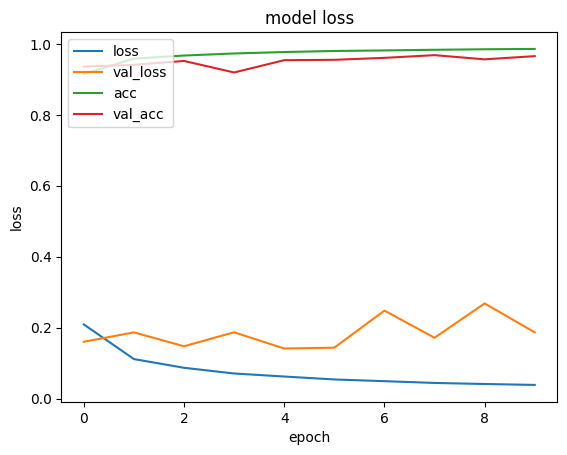

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss', 'acc', 'val_acc'], loc='upper left')
plt.show()

In [17]:
history.history['val_loss']

[0.16035529971122742,
 0.18683487176895142,
 0.14768561720848083,
 0.18708598613739014,
 0.14134538173675537,
 0.14373096823692322,
 0.2481893002986908,
 0.17163951694965363,
 0.2683672308921814,
 0.1868884414434433]

# Load Model

In [18]:
test_movie_files = sorted(glob(TEST_PATH + '/*'))
# test_movie_files[440]
test_movie_files[441]

'/mnt/elice/dataset/test/26ceb386459241b38dfb120bd099919b.mp4'

In [19]:
from keras.models import load_model

In [20]:
model = load_model("/home/elicer/model/Xception-05-0.1413.h5")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 flatten (Flatten)           (None, 51200)             0         
                                                                 
 dense (Dense)               (None, 512)               26214912  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 513       
                                                                 
Total params: 47,076,905
Trainable params: 47,022,377
Non-trainable params: 54,528
_________________________________________________________________


# Predict Test Video
- directory에 있는 test video의 REAL, FAKE 예측
- 프레임 별로 REAL, FAKE를 판단하며 한 영상 프레임들의 결과의 다수결로 영상의 REAL, FAKE 판단
- submission dataframe을 통해 총 3000개의 영상의 REAL, FAKE이 판단되었음을 보여줌.

In [ ]:
%%time

from tqdm import tqdm

detector = MTCNN(margin=50, keep_all=False, post_process=False, device='cuda:0', thresholds=[.3, .3, .3]) #변수 조정
vid_num = 0
scores = []
filenames = []
zero_count_list = []

for vid in tqdm(test_movie_files[:], desc="Processing videos", unit="video"):

    predict_all = []
    count = 0
    file_name_mp4 = vid.split('/')[-1]
    file_name = file_name_mp4.split('.')[0]
    v_cap = cv2.VideoCapture(vid)
    v_len = int(v_cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    for frm in range(v_len):
        success = v_cap.grab()
        if frm % (v_len // 20) == 0:
            success, frame = v_cap.retrieve()
            if not success:
                continue
                
           # 전처리부분추가
        
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = detector(frame)
            if frame is not None:
                frame = np.transpose(frame, (1, 2, 0))
                frame = np.array(cv2.resize(np.array(frame), (160, 160)))
                frame = (frame.flatten() / 255.0).reshape(-1, 160, 160, 3)
                count = count + frame.shape[0]
                predict = model.predict(frame)
                predict_all.append(predict)
            else:
                continue
        else:
            continue
    if count == 0:
        zero_count_list.append(file_name)
        print(file_name)
        
        count += 1

    predict_all.sort()
    final_pred = sum(predict_all[:]) / (count)
    if final_pred == 1:
        final_pred = [[0.99]]
    elif final_pred == 0:
        final_pred = [[0.01]]
        
    scores.append(final_pred[0][0])
    print("score:", final_pred[0][0] * 100)

    filenames.append(file_name_mp4)

v_cap.release()

In [29]:
df = pd.DataFrame({'path':filenames, 'label':scores}) 

df.to_csv('score.csv', index=False)

df = pd.read_csv('/home/elicer/score.csv')

submission = df

In [31]:
submission["label"]=np.where(submission["label"]>=0.5, 1, 0)

In [33]:
submission['label'] = submission['label'].apply(lambda x: 'fake' if x == 1 else 'real')
print(submission)

                                      path label
0     000ee59f529d4d069edee33b887bb2ce.mp4  real
1     0018214f560f4ba3871dd9218f55dd48.mp4  real
2     00241f732f934e2b807cf493d02ff80b.mp4  fake
3     00473872f36940a0bfe3f3dfd7667449.mp4  real
4     004d9c5bee68438397889c71a32a05d5.mp4  real
...                                    ...   ...
2995  ffa0960e6c154c478b6b1781bda78e08.mp4  real
2996  ffa34ed0124f459885b99401fc2f706c.mp4  real
2997  ffd9e5c5e71a4c33a0b63d3676d15d52.mp4  real
2998  ffde5e9809f34b43ae7decca08f37d0c.mp4  fake
2999  fff4f11155264d809045f5de16bd2169.mp4  fake

[3000 rows x 2 columns]
